#### _Speech Processing Labs 2021: SIGNALS 1: Interpreting the Discrete Fourier Transform_

In [1]:
## Run this first! 
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import cmath
from math import floor
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
plt.style.use('ggplot')

from numpy.fft import fft

from dspMisc import *

# Interpreting the Discrete Fourier Transform

### Learning Outcomes

* Identify the relationship bewteen spectrograms, wave decomposition, and the Discrete Fourier Transform (DFT)
* Identify what the DFT does in terms the inputs and outputs
* Interpret the DFT outputs with respect to input sample size and sampling rate
* Interpret the DFT outputs in terms of magnitude and phase spectrum plots


### Background

* Speech Zone videos: up to and including [Frequency Domain](https://speech.zone/courses/speech-processing/module-1-basics-speech-signals/videos/frequency-domain/)
* Reading: R. Waytree (2019) Phonetics: a practical perspective, Chapters 6 and 7


## Introduction

In the module on acoustic phonetics, we looked at how we can map the frequency components of a complex sound wave to changes in articulation.  We can 'see' speech through spectrograms.  

We obtain spectrograms using the **Short-Time Fourier Transform (STFT)**.  This applies the **Discrete Fourier Transform (DFT)** to short windows of the speech signal where each window selects a specific segment of time in the waveform.

Here's an example from praat of the spectrograms generated from me saying a bunch of vowels. The default window size is 5 milliseconds (ms).

<img src="./fig/aiueo.png" alt="spectrogram of vowels /aiueo/" width=800>

We can look also look at spectral slices over in praat by selecting a portion of the vowel.   The first of the two spectral slices below was generated from around 10ms while the second was generated over around 40 ms. You can see that that the spectral slice over the smaller selection is much less detailed. 


#### 10 ms spectral slice
<img src="./fig/small-slice.png" alt="spectral slice over a shorter time span" width=600>


#### 40 ms spectral slice
<img src="./fig/larger-slice.png" alt="spectral slice over a longer time span" width=600>

So, it seems the shape, and particularly the smoothness, of the spectrum changes depending on how much speech you select. The relationship between the input size and the sampling rate of your recording is something you have to know if you want to be able to interpret the output of the DFT (and hence the spectrogram). 

In this notebook we'll take a fairly high level look at the DFT, emphasizing some of the more practical aspects of interpreting the output.  We should note though that the Fourier Transform is essentially a mathematical tool.  Standard textbooks, like Jurafsky and Martin, will present the DFT as a set of equations.  We don't expect you to understand all the maths behind this for this course. The main goal is to give you enough details about the DFT for you to be able to understand the following: 

* What does the DFT tell you about the the input signal? 
* What is the output of the DFT? How do you interpret it? How does it relate to what you see in a Spectrogram? 
* How does the size of the input effect the output? 
* What digital aspects of the input affect the output?

If you want to get a deeper understanding of what this is, a mathematical understanding will eventually become essential. For this reason, We've included some extension material in a separate notebook that [goes through the DFT equations in detail](./signals-1-4-discrete-fourier-transform) but please note that that is purely extension material.  

This notebook provides some more background and visualization code so that you can do the exercises at the end of the notebook. 




## Fourier Analysis: Sound waves as sums of sinusoids

You've seen in the course videos (e.g. [Fourier Analysis](https://speech.zone/courses/speech-processing/module-1-basics-speech-signals/videos/fourier-analysis/)) that we can break down complicated waveforms into a combination of simpler components, specifically **sinusoids** of different frequencies. This is basically what the Discrete Fourier Transform _does_.  

![Compound waveform decomposition into sine waves](fig/compound_waveform.png)

In this picture, you should see a somewhat complicated waveform on the left and the 3 sinusoidal (i.e., [pure tone](https://en.wikipedia.org/wiki/Pure_tone)) components on the right (8 Hz, 20 Hz, 36 Hz).  We can decompose the waveform on the left into the three on the right. Each of these components has a different **peak amplitude**.  You might also notice that the first and the third components start with value 1 at time zero: they're actually cosine waves rather than sine waves. When we add (or **superimpose**) these 3 waves together over the same time interval, we get back the waveform on the left. 

The Fourier Transform is the tool we use to break down complicated periodic waveforms into sinusoidal components representing specific frequencies. For speech sounds, the relative magnitudes of these frequency components affects what phones/words/sentences we hear. 

For the moment, we can think of the Fourier Transform as a tool that takes a sequence of measurements in time as input and outputs a sequence of values that tell you what pure tones you would need to recreate the orignal waveform. This tool is made of maths, so if you don't know what it's actually doing you might get a bit of a shock if you just apply some 'off-the-shelf' version unless you know how to interpret the output!  



## The DFT at work

The Fourier Transform is truly a keystone of modern engineering, so it's actually quite easily to find implementations that you can use in different programming languages. Let's have a look at what output you get from a standard python implementation (from the `numpy` package).  

To illustrate this, we'll first have to generate some input. So, here's some code to generate simple sine wave (220 Hz).  You'll notice that since we're in the digital world, we have to approximate the sine wave with a sequence of points (amplitude measurements) in time. This means we have specify a **sampling rate**, which tells the computer how often we took those amplitude measurements (samples/second).  The sampling rate is a very important factor in interpreting the DFT outpu (we'll  come back to this!).  

Now, let's generate 220Hz sine wave with a 8000 Hz sampling rate for 0.2 seconds and plot it.


Text(0.5, 1.0, 'Input: $x[n]$ in the time domain')

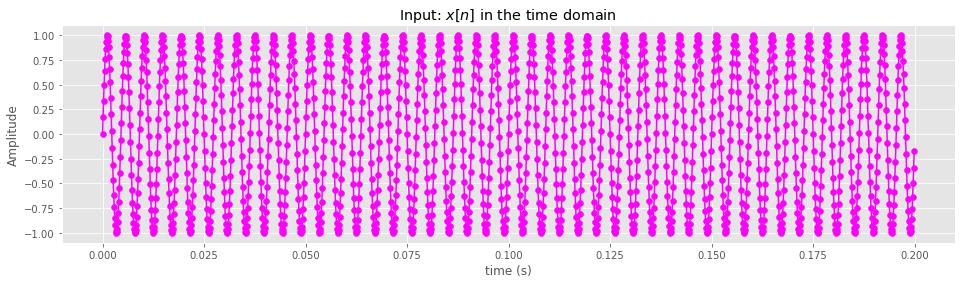

In [2]:
#sampling rate, let's say 8000 Hz, like a telephone 
sampling_rate = 8000

# length in seconds 
total_wav_time = 0.2

# calculate the number of samples to generate given the sampling rate and desire waveform length
n_samples = int(total_wav_time * sampling_rate)

# the sine wave frequency
f_in = 220

# a pre-defined function for generating sinusoids
x, time_steps = gen_sinusoid(frequency=f_in, phase=0, amplitude=1, sample_rate=sampling_rate, seq_length=n_samples, gen_function=np.sin)

## Plot the input
fig, timedom = plt.subplots(figsize=(16, 4))
timedom.scatter(time_steps, x, color='magenta')
timedom.plot(time_steps, x, color='magenta')
timedom.set_xlabel("time (s)")
timedom.set_ylabel("Amplitude")
timedom.set_title("Input: $x[n]$ in the time domain")

Now let's apply the [Fourier Transform Function](https://numpy.org/doc/stable/reference/routines.fft.html) that comes with the `numpy` and plot the output.

Note: We use the Fast Fourier Transform (`fft`) function here: this is an algorithm that performs the Discrete Fourier Transform but uses some clever short cuts to get the outputs in a more efficient (fast) manner.  We won't be covering the details that make this fast in this class, but rest assured it does make things much faster and it's almost certainly the version that you will use when you do the Fourier Transform in an application.  

the number of input samples was 1600
the number of fft outputs was 1600


(7730.0, 7830.0)

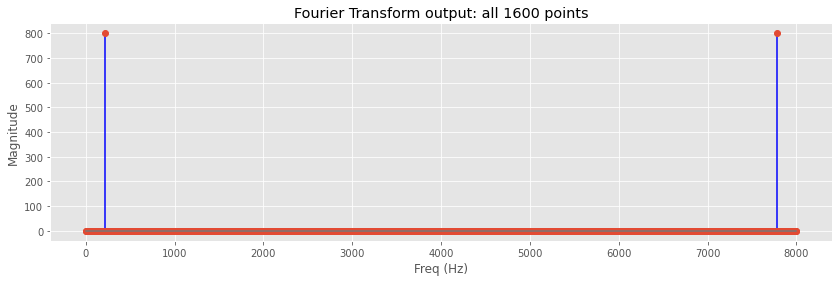

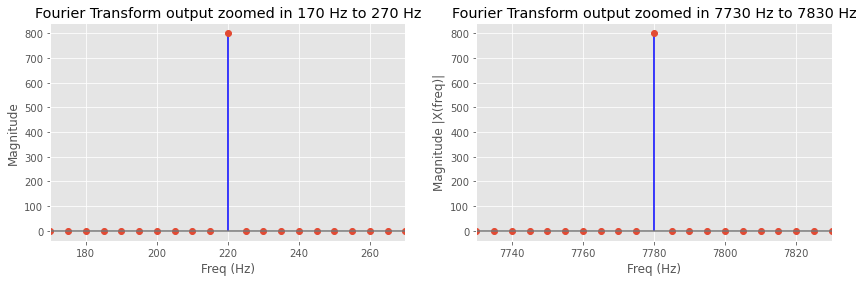

In [3]:
from numpy.fft import fft
## Apply the Fourier Transform to our input sine wave 
## The convention is that the DFT outputs are referred to with capital letters
X = fft(x)

## N is the number of fft (i.e. DFT) outputs
N = len(X)

## Let's just check this s the same as the number of input samples
print("the number of input samples was %d" % x.shape)
print("the number of fft outputs was %d" % N)

## Now plot the line spectrum: the actual output depends on the number of input samples and the sampling rate
## We'll unpack this later! 

# n is the sequence of integers 0,1,...,N-1
n = np.arange(N)

## We calculate the fundamental period of the DFT, 
## this corresponds to the period of the lowest frequency we can analyse, i.e., 1/T
## Note that this is dependent on the number of samples and the sampling rate
T = N/sampling_rate

## The outputs correspond to multiples
## Why? See NOTEBOOK
output_frequencies = n/T 

## The line spectrum shows magnitudes associated with different frequency components
## We calculate these as the absolute values of the the DFT outputs
## Why? See below and NOTEBOOK

magnitudes = np.abs(X)

## Now we have frequencies and magnitudes that the DFT outputs represent
## let's plot the output as a line spectrum (~Spectral Slice in praat)

## First we set the plot size
plt.figure(figsize = (14, 4))

## Now plot the whole line spectrum (magnitude of FFT outputs) on the top left

## We plot the 
plt.stem(output_frequencies, magnitudes, 'b', use_line_collection=True) 
plt.xlabel('Freq (Hz)')
plt.ylabel('Magnitude')
plt.title('Fourier Transform output: all %d points' %N)

plt.figure(figsize = (14, 4))

## Let's zoom into the region around 220 Hz +- 50 Hz on the top right
plt.subplot(121)
plt.stem(output_frequencies, magnitudes, 'b', use_line_collection=True)
plt.xlabel('Freq (Hz)')
plt.ylabel('Magnitude')
plt.title('Fourier Transform output zoomed in %d Hz to %d Hz' % (f_in-50, f_in+50))
plt.xlim(f_in-50, f_in+50)

## Let's zoom into the region around sampling_rate-220 Hz +- 50 Hz on the bottom right
plt.subplot(122)
plt.stem(output_frequencies, magnitudes, 'b', use_line_collection=True) 
plt.xlabel('Freq (Hz)')
plt.ylabel('Magnitude |X(freq)|')
plt.title('Fourier Transform output zoomed in %d Hz to %d Hz'  % (sampling_rate-f_in-50, sampling_rate-f_in+50))
plt.xlim(sampling_rate-f_in-50, sampling_rate-f_in+50)

There are a few things you can immediately notice:

* The number of DFT outputs (1600) matches the number of input samples we used to represent our sine wave (1600)
* We get a spike at 220 Hz, which was the frequency of our input sine wave
* We also get a spike at 7780 Hz (i.e, 8000-220Hz)

Our input definitely didn't have a 7780Hz frequency component so how come we see it in the Fourier Transform output? It turns out the full DFT output is mirrored around the **Nyquist Frequency**, that is half the sampling rate. This happens for the same reason [_aliasing_ happens](https://speech.zone/courses/speech-processing/module-1-basics-speech-signals/videos/digital-signal/), which we'll explore more in [this notebook](./signals-1-2-sampling-sinusoids.ipynb).

<div class="alert alert-success" role="alert">
For N input samples, The DFT outputs represent N frequencies evenly spaced between 0 Hz and the sampling rate, but we can only actually analyze frequencies up to half the sampling rate (i.e., the Nyquist Frequency) 
</div>


In fact, if you check the spectogram or spectral slices shown in praat, you'll see it only shows values up to the Nyquist Frequency for the input recording (e.g., the sampling rate of the example at the beginning of this notebook was 44100 Hz).  

Another thing you might be asking is why we took the absolute value of the DFT output to get the values on the line spectrum.  The answer is that the output of the DFT is actually a sequence of _complex numbers_ and taking the absolute value gives us the _magnitude_ of each of those complex numbers.

Let's look at the output to check:

In [4]:
print("If we plot the whole output vector, numpy won't show all of it if the vector is big:\n")
print(X)

print("\n\nBut we can inspect the first 50 outputs like so:\n")
print(X[0:50])


If we plot the whole output vector, numpy won't show all of it if the vector is big:

[-3.02920488e-13+0.00000000e+00j  9.95336397e-14-1.96397164e-13j
  6.03454138e-14+1.72500718e-14j ...  9.32121522e-14+2.58270280e-14j
  6.03454138e-14-1.72500718e-14j  9.95336397e-14+1.96397164e-13j]


But we can inspect the first 50 outputs like so:

[-3.02920488e-13+0.00000000e+00j  9.95336397e-14-1.96397164e-13j
  6.03454138e-14+1.72500718e-14j  9.32121522e-14-2.58270280e-14j
  3.66658212e-14+6.33937347e-14j  3.34809102e-14+3.05307501e-14j
 -4.96468554e-15+4.93801232e-14j  3.34594531e-15+1.84716149e-14j
 -2.33578152e-14+2.63612404e-14j -3.29172588e-14+4.34903580e-15j
 -4.41043976e-14-3.53982599e-14j -2.29807676e-14+8.38045350e-15j
 -7.72430611e-14-3.59712260e-14j  1.32587136e-14-8.55966711e-14j
 -2.79599183e-14-5.28178687e-14j  1.26546196e-14-5.83161926e-14j
 -3.44274706e-14-7.77122651e-14j  8.77374766e-15-7.57162655e-14j
 -1.59673419e-14-9.94914818e-14j  1.05242883e-14-6.53298024e-14j
 -7.96514435

These numbers look complicated because they are, in fact, _complex numbers!_
Looking at bit closer, you'll see that the outputs are made up of a sum of the form: $a + jb$, where $a$ is the real part and $bj$ is the _imaginary_ part. 

The [next notebooks](./signals-1-2-sampling-sinusoids.ipynb) will go into more depth about why the DFT output is complex.  But for now we can interpret each element of the DFT output as a 2 dimensional coordinate, with the real values on the x-axis and the imaginary values on the y-axis.  

The complex numbers printed above are a bit hard to read because actually most of them are very close to zero. We can see this if we extract the real and imaginary parts of the outputs and round them to two decimal places. The following shows that the real and imaginary parts of output 22 (`X[22]`) are both zero, while output 44 has 0 real part but -800 for the imaginary part. 

Let's round the some of the outputs to make them more readable. The 44th output represents 220Hz.




In [2]:
n_out = 22
print("DFT output X[%d]=%.2f +%.2fj" % (n_out, X[n_out].real, X[n_out].imag))

n_out = 44
print("DFT output X[%d]=%.2f +%.2fj" % (n_out, X[n_out].real, X[n_out].imag))

n_out = 1600-44
print("DFT output X[%d]=%.2f +%.2fj" % (n_out, X[n_out].real, X[n_out].imag))


NameError: name 'X' is not defined

Now let's plot all the DFT outputs as 2 dimensional coordinates: the real component on the x axis and the imaginary component on the y-axis.  

In [6]:
## move to imports
def plot_dft_complex(X, xlim=(-900,900), ylim=(-900,900), figsize=(5,5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.set(xlim=xlim, ylim=ylim)
    
    ax.plot([xlim[0]-100,xlim[1]+100], [0,0], color='grey', zorder=0)
    ax.plot([0,0],[ylim[0]-100,ylim[1]+100], color='grey', zorder=0)
    
    ## Plot all DFT outputs in terms of with (real, imaginary) coordinates
    ax.scatter(X.real,X.imag, zorder=10)
    
    ax.set_xlabel("the real component")
    ax.set_ylabel("the imaginary component")
    return fig, ax

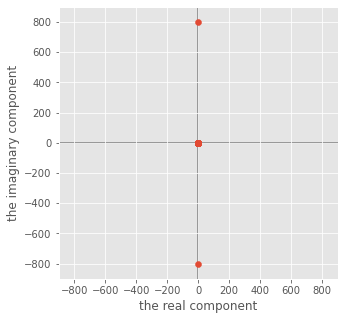

In [7]:
## plot all the DFT outputs on the complex plane
fig, ax = plot_dft_complex(X)

The red points represent the DFT outputs as complex numbers. As expected, we see that most of the outputs are at (0,0), but we see two components that sit away from (0,0) at the points (0,800) and (0,-800), i.e. have non-zero magnitude. As in the line spectrum above, these correspond to the 44th output and the N-44th output (remember N was the input sample length).

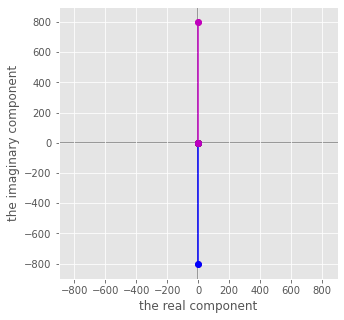

In [8]:
## highlight the outputs 44th and N-44th components
ax.plot([0,X[44].real],[0,X[44].imag], "bo-", zorder=20)
ax.plot([0,X[N-44].real],[0,X[N-44].imag], "mo-", zorder=21)
fig

The graph above shows that: 
*  All of the outputs sit at (0,0), the magnitude (i.e. absolute value) is 0 $\rightarrow$ it's zero distance from (0,0), except: 
* `X[44]` (blue dot) which sits at (0, -800), the distance from (0,0) is 800 $\rightarrow$ magnitude 800
* `X[1566]` (magenta dot) sits at (0, 800), the distance from (0,0) is 800  $\rightarrow$ magnitude 800

Which reflects what we saw in the spectrum plot (0-8000Hz) above. These outputs sit on the y-axis (i.e. a 90 degree rotation from (1,0)) tells us that the input was in fact a sine wave, as opposed to a cosine wave, since a sine wave is just a cosine wave with a 90 degree phase shift. You'll usually see this written as the following identity: $\sin(\theta) = \cos(\theta - \pi/2)$, since 90 degrees = $\pi/2$ radians and for most of our purposes working in radians to express angles is easier. 

### Exercise 

In the `gen_sinusoid` function above (where we generated the sine wave input), set `gen_function=np.cos` to make it generate a cosine wave instead of a sine wave.  You'll notice that it looks just like the previous sine wave but shifted to start at a peak instead of a zero (and then rising to a peak).

Now have a look at the DFT output for this 220 Hz cosine wave.  What's the difference in the outputs in the line spectrum? How about in the complex plane?  



#### Notes 

## A more complex input

Let's try now with a more complicated input, where we combine a cosine wave with frequency 60 Hz and a peak amplitude of 1, and a cosine wave with frequency 100 Hz, amplitude of 0.6 and a _phase shift_ of 90 degrees.

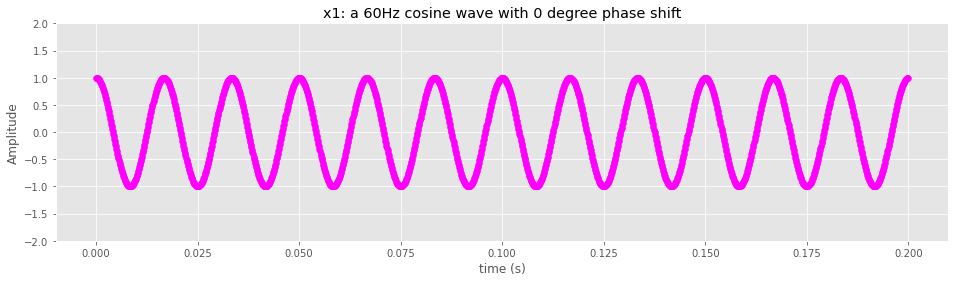

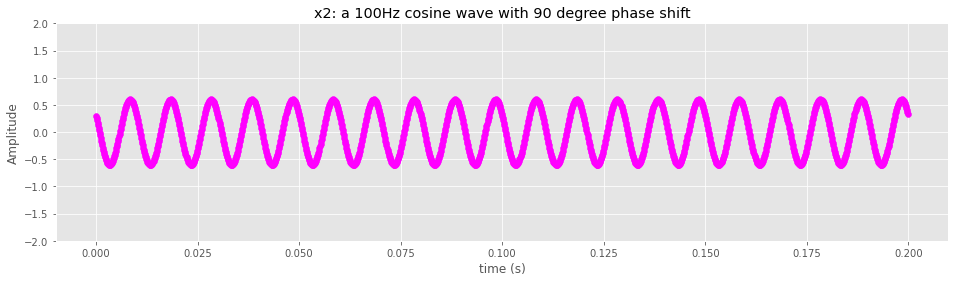

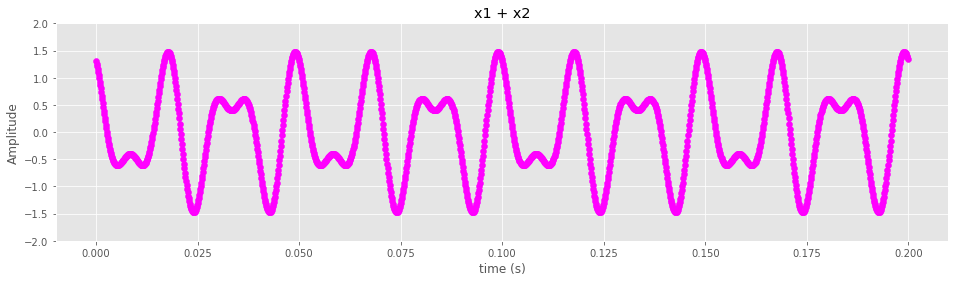

In [9]:
#sampling rate, let's say 8000 Hz, like a telephone 
sampling_rate = 8000

# length in seconds 
total_wav_time = 0.2

n_samples = int(total_wav_time * sampling_rate)

freq1 = 60
freq2 = 100

x1, time_steps = gen_sinusoid(frequency=freq1, phase=0, amplitude=1, sample_rate=sampling_rate, seq_length=n_samples, gen_function=np.cos)
x2, time_steps = gen_sinusoid(frequency=freq2, phase=np.pi/3, amplitude=0.6, sample_rate=sampling_rate, seq_length=n_samples, gen_function=np.cos)

x = x1 + x2

fig, timedom = plot_waveform(time_steps, x1, title="x1: a 60Hz cosine wave with 0 degree phase shift")
fig, timedom = plot_waveform(time_steps, x2, title="x2: a 100Hz cosine wave with 90 degree phase shift")
fig, timedom = plot_waveform(time_steps, x1+x2, title="x1 + x2")

the number of input samples was 1600
the number of fft outputs was 1600


(<Figure size 1008x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcb6507d730>)

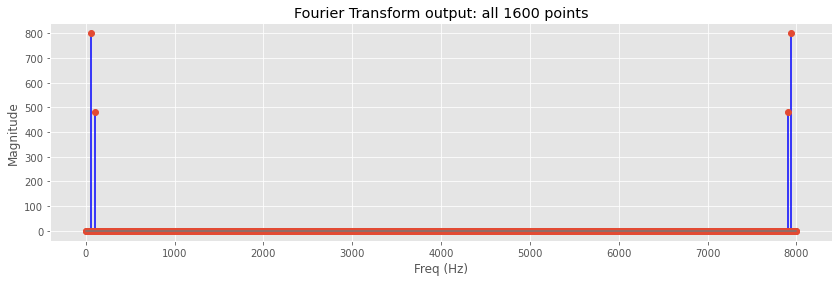

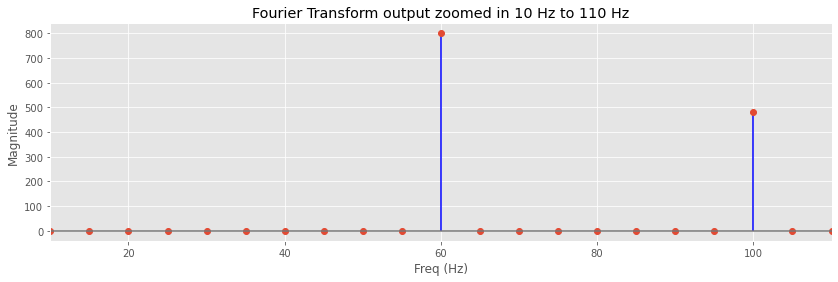

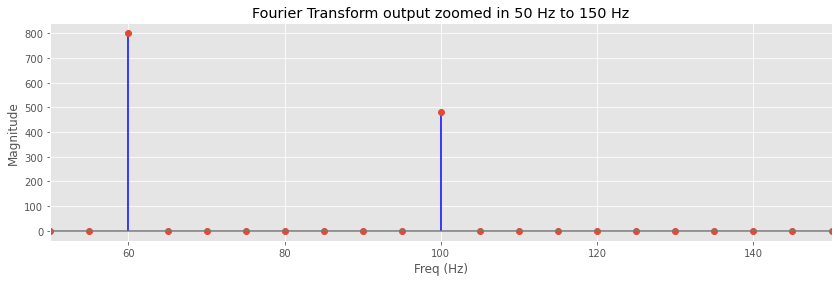

In [10]:
## Apply the Fourier Transform to our input sine wave 
X = fft(x)

## N is the number of fft (i.e. DFT) outputs
N = len(X)

## Let's just check this s the same as the number of input samples
print("the number of input samples was %d" % x.shape)
print("the number of fft outputs was %d" % N)

## Now plot the line spectrum: the actual output depends on the number of input samples and the sampling rate
## We'll unpack this later! 

# ks is a sequence of integers 0,1,...,N-1, corresponding to our DFT outputs
K = np.arange(N)

## We calculate the fundamental period of the DFT, 
## this corresponds to the period of the lowest frequency we can analyse, i.e., 1/T
## Note that this is dependent on the number of samples and the sampling rate
T = N/sampling_rate

## The outputs correspond to multiples of 1/T = sampling_rate/N
## Why? See NOTEBOOK
output_frequencies = K/T 

## The line spectrum shows magnitudes associated with different frequency components
## We calculate these as the absolute values of the the DFT outputs
## Why? See below and NOTEBOOK

magnitudes = np.abs(X)

## Now we have frequencies and magnitudes that the DFT outputs represent
## let's plot the output as a line spectrum (~Spectral Slice in praat)


## Now plot the whole line spectrum (magnitude of FFT outputs) on the top left

plot_mag_spectrum(output_frequencies, magnitudes, title='Fourier Transform output: all %d points'%N)

## Let's zoom into the region around 60 Hz +- 50 Hz 
zoom_mag_spectrum(output_frequencies, magnitudes, center=freq1, window=50, 
                                title='Fourier Transform output zoomed in %d Hz to %d Hz' % (freq1-50, freq1+50))

## Let's zoom into the region around sampling_rate-60 Hz +- 50 Hz 
zoom_mag_spectrum(output_frequencies, magnitudes, center=freq2, window=50, 
                                title='Fourier Transform output zoomed in %d Hz to %d Hz' % (freq2-50, freq2+50))


As expected, we can see spikes at 60Hz and 100 Hz.  These are also mirrored at 8000-60=7940 Hz and 8000-100=7900 Hz.  We can also see that the 60 Hz spike is bigger than the 100 Hz spike.  This is also expected, since we created the input with the 100Hz component at half the amplitude of the 60 Hz component. 

Now let's plot the DFT outputs on the 2 dimensional complex number plane: 


In [11]:
## figure out what DFT outputs correspond to our input frequencies
out1 = int(freq1/(sampling_rate/N))
out2 = int(freq2/(sampling_rate/N))
print("The indices corresponding to input frequencies: %d, %d" % (out1, out2))

The indices corresponding to input frequencies: 12, 20


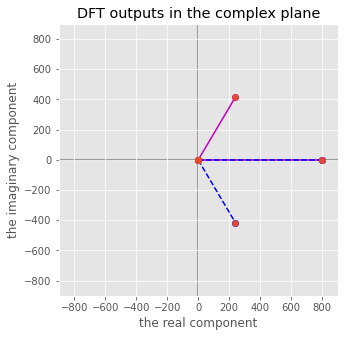

In [12]:
fig, ax = plot_dft_complex(X)
ax.set_title("DFT outputs in the complex plane")

## Plot the outputs representing 60 Hz and 100 Hz (magenta)
ax.plot([0,X[out1].real],[0,X[out1].imag], "mo-")
ax.plot([0,X[out2].real],[0,X[out2].imag], "mo-")


## Plot the outputs representing 8000-60Hz and 8000-100Hz (the mirrored components, in blue) 
ax.plot([0,X[N-out1].real],[0,X[N-out1].imag], "bo--")
ax.plot([0,X[N-out2].real],[0,X[N-out2].imag], "bo--")


In [13]:
print("Convert complex numbers to polar form: magnitude and angle")
print("mag=%.2f, angle=%.2f radians" % cmath.polar(X[out1]))
print("mag=%.2f, angle=%.2f radians" % cmath.polar(X[out2]))
print("mag=%.2f, angle=%.2f radians" % cmath.polar(X[N-out1]))
print("mag=%.2f, angle=%.2f radians" % cmath.polar(X[N-out2]))

# pi radians = 180 degrees
# 1 radian = 180/np.pi

print("%.2f radians is %.2f degrees" % (cmath.polar(X[out2])[1], round(cmath.phase(X[out2]) * (180/np.pi))))

Convert complex numbers to polar form: magnitude and angle
mag=800.00, angle=-0.00 radians
mag=480.00, angle=1.05 radians
mag=800.00, angle=0.00 radians
mag=480.00, angle=-1.05 radians
1.05 radians is 60.00 degrees


The graph above shows (magenta):
* 60 Hz: magnitude=800, angle=0 radians = 0 degrees 
* 100 Hz: magnitude=580, angle=1.05 radians = 60 degrees

Where we measure the magnitude as the length of the vector (straight line to the coordinate), and the angle (aka phase) as the angle between the vector and the positive x-axis.  

And similarly for the mirrored versions:
* 8000-60 Hz: magnitude 800, angle 0 radians = 0 degrees
* 8000-100 Hz: magnitude 580, -1.05 radians = -60 degrees

The angle (aka the phase) of the DFT output tells us that if we were to try to reconstruct the 
original waveform from the non-zero frequency components, we'd have to shift the 100 Hz component by the equivalent of 60 degrees (pi/3 radians) from a pure cosine wave.  The 60 Hz component has an angle 0 (0 degrees phase shift), so we can take it to be a regular old cosine wave.  Indeed, this is how we constructed the input! 

<div class="alert alert-success" role="alert">
Each DFT output is a complex number, which we can think of as a vector in the 2-D complex plane.  
In polar form, these complex numbers are characterized by a magnitude and a phase angle.  Each output also corresponds to a cosine wave of a specific frequency. The magnitude of the output tells us how big the corresponding cosine wave is, and the phase angle tells us how much we have to shift that cosine wave from it's usual starting point of (0,1) in the time vs amplitude graph. 
</div>

## Summary: Some things you should know about the DFT

* When the input to the DFT is a sequence of $N$ real numbers, the DFT outputs are a sequence of $N$ complex numbers. 
    * e.g., Since our input was a sequence of 1600 points sampled from a 220 Hz sine wave, our output was 1600 complex numbers. 


* The lowest frequency that the DFT output can capture is `sampling_rate/N` Hz and the other analysis frequences are all integer multiples of this.  The frequency associated with DFT[k] is $kf_s/N$ for $k=0,...,N-1$, where $f_s$ is the sampling rate. 
    * e.g. with a sampling rate of 8000 Hz and an input of 1600 points, the lowest frequency `X[1]` is 8000/1600 = 5 Hz
    * For the example above, this is why the 44th output represents 220Hz (44x5 Hz = 220 Hz)
    * The very first DFT output, `X[0]` maps to 0Hz.  This actually tells us the bias of the signal with respect to the amplitude. 


* The less input samples $N$ you have, the fewer frequencies you can analyze using the DFT.  
    * You'll see this in praat when you compare a spectral slice taken over varying amounts of the waveform. 


* If the input waveform includes a sinusoidal ('pure tone') component of frequency $kf_s/N$, we will observe a non-zero magnitude for DFT[k]. 
    * This why we see a spike at the 44th output (220 Hz) in the spectrum 
    * We calculate the magnitude by taking the absolute value of the DFT output,  this essentially tells us how far away the output $a+bj$ (i.e, the coordinate $(a,b)$) is from $0+0j$ (i.e, the coordinate $(0,0)$) and is proportional to the peak amplitude of that frequency component. 
    * This decomposition works perfectly in theory, but in practice we don't always fully meet the assumptions get a perfect decomposition in to a line spectrum. Due to our need to sample and do short-time analysis, a non-zero magnitude doesn't always mean that the input includes that frequency component. One case where this happens is when the input frequency falls between DFT output frequencies: see the exercise below.



* The full output of the DFT is mirrored around the _Nyquist Frequency_, i.e., half the sampling rate.
    * This is 8000/2 = 4000 Hz in the example above, where we see spikes in the spectrum for both the 44th and 1600-44=1566th outputs representing 220Hz.
    * This arises from the fact that we are in the digital world, working with a finite number of discrete samples (see [the notebook on digital signals and aliasing](./signals-3-sampling-sinusoids.ipynb))
    * When we plot the output as complex numbers, we see that the mirrored "spikes" have the same magnitude (distance from zero) but are actually in different but still mirrored positions (same angle from (1,0)).


* Because of this mirroring property, we generally only work with the first N/2 outputs: for a speech processing purposes we're only really concerned with the overall shape of the spectrum (the spectral envelope). But if you want to reconstruct the original waveform from the DFT output (yes you can!) then you need the whole output. 


### What next?
You may be asking yourself: How could I possibly figure this out for myself? The answer is that you can't really do this based only on an intuitive understanding of the Fourier Transform. Without understanding the how the DFT really works you, just have to take these as given. 

As mentioned previously, the DFT is a foundational element of signal processing (and a lot of other things).  As such, there are a lot of implementations already out there for you to use, rather than coding it up from scratch yourself.  However, hopefully the examples above and exercises below show that you do need to know what it actually does to interpret the results, even if you're not implementing the DFT yourself. 

So, you don't need to know all the maths for this course but, again, it's a good idea to at least be aware of what the DFT actually does. This will be important when we look at the inputs and outputs of Automatic Speech Recognition and Text-to-Speech Systems. 
 
* Next: [Digital Signals: Sampling sinusoids](./signals-1-2-sampling-sinusoids.ipynb)
     
Extra maths/background, if you're looking for more detail (not examinable): 
* [Complex numbers and sinusoids](./signals-1-2-digital-signals-complex-numbers.ipynb)   
* [The Discrete Fourier Transform in Detail](./signals-1-3-discrete-fourier-transform-in-detail.ipynb)
* [More on Interpreting the DFT](./signals-1-4-more-interpreting-the-dft.ipynb)

## Exercises 


Modify the code below to investigate how the DFT outputs change when you change the sampling rate, size of input, and the input frequency and phase: 

* **Time resolution:** What's the effect of making `total_wav_time` shorter but keeping `sampling_rate` and `freq1` and `freq2` the same? 


* **Frequency resolution:** What's the effect of reducing the `sampling_rate` but keeping everything else the same? 
    * What are the mirrored frequencies when `sampling_rate=4000` vs `sampling_rate=400`


* **Aliasing:** What happens when `sampling_rate=400` but `freq2=220`?  How about `freq2=300`?


* **Phase shifts:** What happens when you change the phase when you generate `x2`, e.g. in `gen_sinusoid` change `np.pi/3` (i.e. 60 degrees) to `3*np.pi/4`
    * What does this do to `x2`? e.g. how much is it shifted relative the a cosine with no phase shift


* **Bias:** What happens if you move the whole waveform up by a constant, e.g. change `x = x1 + x2` to `x = x1 + x2 + 0.5`?    
* What happens if you change `sample_rate=800`, `total_wav_time=0.05`? How many input samples do you now have? What frequencies are analyzed? 
    * **leakage** Now what happens if you change `freq2=110`?  That is, what happens when the frequency of the input component doesn't exactly match one of the output frequencies?


* **Cancellation** What happens if you change `freq1=60` and `freq2=60` but include a phase shift for `x2`? What happens if the `phase=np.pi`? What about if you change `phase=np.pi` and set make the amplitudes for `x1` and `x2` the same, e.g. `amplitude=1`?






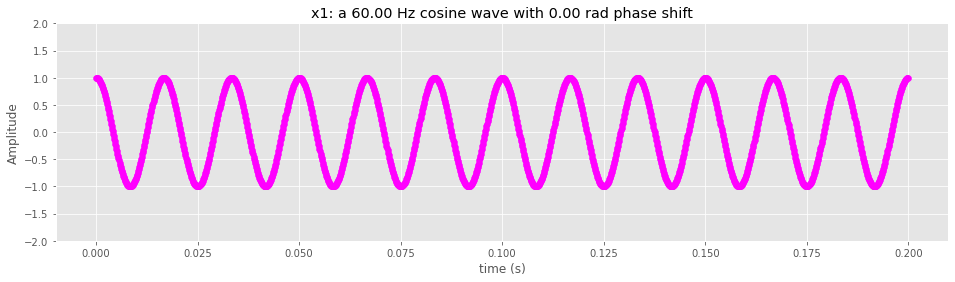

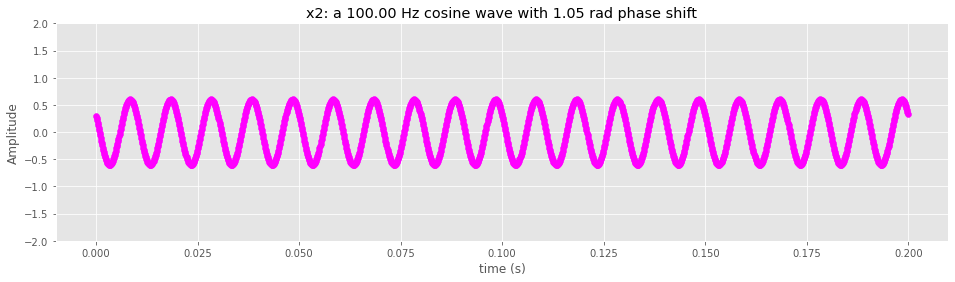

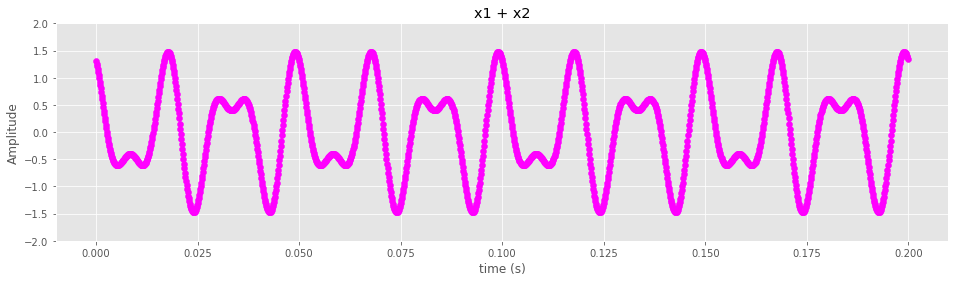

In [14]:
#sampling rate, let's say 8000 Hz, like a telephone 
sampling_rate = 8000

# length in seconds 
total_wav_time = 0.2

n_samples = int(total_wav_time * sampling_rate)

freq1 = 60
freq2 = 100

phase1 = 0
phase2 = np.pi/3

amp1 = 1
amp2 = 0.6

x1, time_steps = gen_sinusoid(frequency=freq1, phase=phase1, amplitude=amp1, sample_rate=sampling_rate, seq_length=n_samples, gen_function=np.cos)
x2, time_steps = gen_sinusoid(frequency=freq2, phase=phase2, amplitude=amp2, sample_rate=sampling_rate, seq_length=n_samples, gen_function=np.cos)

x = x1 + x2 

## Plot the input
fig, timedom = plot_waveform(time_steps, x1, title="x1: a %.2f Hz cosine wave with %.2f rad phase shift" %(freq1, phase1) )
fig, timedom = plot_waveform(time_steps, x2, title="x2: a %.2f Hz cosine wave with %.2f rad phase shift" % (freq2, phase2))
fig, timedom = plot_waveform(time_steps, x1+x2, title="x1 + x2")


the number of input samples was 1600
the number of fft outputs was 1600
minimum analysis frequency is 5.00 Hz


Text(0.5, 1.0, 'DFT: Phase spectrum: all 1600 points')

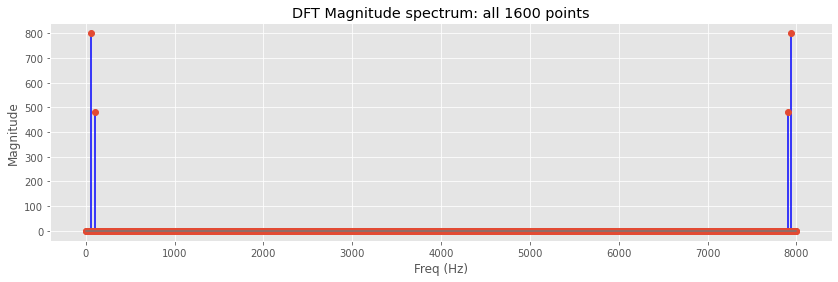

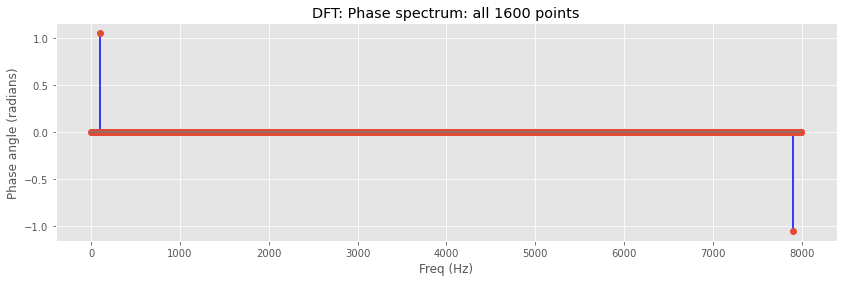

In [16]:
## Apply the Fourier Transform to our input sine wave 
X = fft(x)

## N is the number of fft (i.e. DFT) outputs
N = len(X)

## Let's just check this s the same as the number of input samples
print("the number of input samples was %d" % x.shape)
print("the number of fft outputs was %d" % N)

## Now plot the line spectrum: the actual output depends on the number of input samples and the sampling rate
## We'll unpack this later! 

# n is the sequence of integers 0,1,...,N-1
n = np.arange(N)

## The outputs correspond to multiples of sampling_rate/N
output_frequencies = n *(sampling_rate/N) 

print("minimum analysis frequency is %.2f Hz" % float(sampling_rate/N))

## Since we know now that the output of the DFT is a sequence of complex numbers
## let's use some python builtin functions to convert them to polar notation, i.e. magnitude and phase
## This way we can read off the magnitude and phase spectrums easily

dft_polar = [cmath.polar(z) for z in X]

magnitudes = np.array([m for m, _ in dft_polar])

## The way the angle is calculated sometimes results in floating point errors 
## (i.e. accidental division by a very small number), 
## so we only calculate phase if the magnitude is significantly bigger than zero
phases = np.array([ph if mag > 0.000001 else 0 for mag, ph in dft_polar])

## Now we have frequencies and magnitudes that the DFT outputs represent
## let's plot the output as a line spectrum (~Spectral Slice in praat)


## Now plot the whole line spectrum (magnitude of FFT outputs) on the top left

plt.figure(figsize = (14, 4))
plt.stem(output_frequencies, magnitudes, 'b', use_line_collection=True) 
plt.xlabel('Freq (Hz)')
plt.ylabel('Magnitude')
plt.title('DFT Magnitude spectrum: all %d points' %N)

## We can also plot the phase spectrum

plt.figure(figsize = (14, 4))
plt.stem(output_frequencies, phases, 'b', use_line_collection=True) 
plt.xlabel('Freq (Hz)')
plt.ylabel('Phase angle (radians)')
plt.title('DFT: Phase spectrum: all %d points' %N)


12 20


[(-1040.0, 1040.0), (-1040.0, 1040.0)]

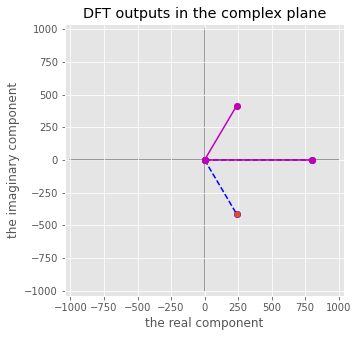

In [17]:
out1 = int(freq1/(sampling_rate/N))
out2 = int(freq2/(sampling_rate/N))
print(out1, out2)

fig, ax = plot_dft_complex(X)
ax.set_title("DFT outputs in the complex plane")
ax.plot([0,X[out1].real],[0,X[out1].imag], "mo-", zorder=20)
ax.plot([0,X[out2].real],[0,X[out2].imag], "mo-", zorder=22)

ax.plot([0,X[N-out1].real],[0,X[N-out1].imag], "bo--")
ax.plot([0,X[N-out2].real],[0,X[N-out2].imag], "bo--")

## resize the plot if it's too zoomed out or in
boxsize=np.max(magnitudes) + (np.max(magnitudes)*0.3)
ax.set(xlim=(-boxsize, boxsize), ylim=(-boxsize, boxsize))



## Notes

_You can use this space to make notes!_